In [1]:
import os, time
from copy import deepcopy
import numpy as np
from helpers import copy_sd, res_to_cpu, gen_corr
import pickle

# Pytorch
import torch
from tqdm import tqdm
use_cuda = True
if torch.cuda.is_available() and use_cuda:
    device = torch.device('cuda')
    print("Use cuda.")
else:
    device = torch.device('cpu')
    print("Use cpu.")
from torch.optim import Adam, SGD

# Figures 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from style import colors
from fig_specs import *

from rnn_model_dt import RNN_Net
from task_generators import simple_sine as task_generator
task_name = "simple_sine"

scenarios = [
    # 'marginal',
    # 'lazy',
    'oblique',
    # 'aligned',
    # "oblique_decaying",
    # "oblique_unstable",
    # "oblique_input",
    # 'aligned_decaying',
    # 'aligned_unstable',
    # 'aligned_noisy',
]


Use cpu.


oblique


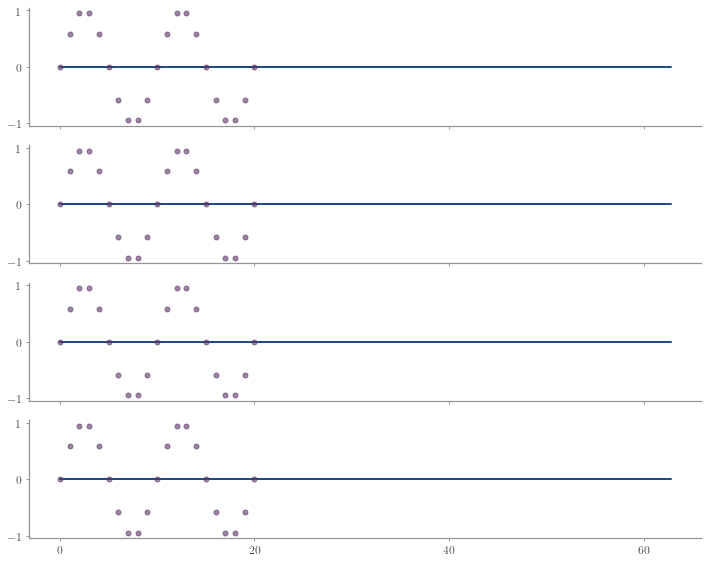

100%|██████████| 1000/1000 [12:50<00:00,  1.30it/s]


Took 771.8 sec.
Saved to  ../../data/oblique/simple_sine_example_oblique_n_512.pkl


In [2]:
for i_sce, scenario in enumerate(scenarios):
    print(scenario)
    
    # Parameters
    n_samples = 1

    # Network
    dim_hid = 512
    dim_in = 1
    dim_out = 1
    n_layers = 2
    bias = False
    train_in = False
    train_hid = True
    train_out = False
    train_layers = [train_in, train_hid, train_out]
    nonlin = torch.nn.Tanh()
    gaussian_init = True
    dt = 0.2

    rec_step_dt = 1
    mask_step_dt = 5
    t_dec = 21
    target_amp = 1
    task_params = dict(
        t_dec=t_dec,
        target_amp=target_amp,
        rec_step_dt=rec_step_dt,
        mask_step_dt=mask_step_dt,
    )

    n_steps = 1000
    opt_gen = Adam
    n_mi = n_samples,

    
    # Parameters subject to change below (depending on the scenario)
    # 
    g = 1.5
    out_scale = 'large'
    h_0_std = 1.
    # Noise on input, h_0, and hidden states
    noise_input_std = 0.0
    noise_init_std = 0.0
    noise_hid_std = 0.0

    # Optimization
    if scenario.startswith("marginal"):
        lr0 = 2e-3
        g = 0.7
        h_0_std = 1 / np.sqrt(dim_hid)
    elif scenario == "lazy":
        lr0 = 1e-3
    elif scenario.startswith("oblique"):
        lr0 = 5e-2
        noise_input_std = 0.0
        noise_init_std = 1.0
        noise_hid_std = 1.0
        if scenario == "oblique_decaying":
            g = 0.7
        elif scenario == "oblique_unstable":
            lr0 = 5e-1
            g = 3
        elif scenario == "oblique_input":
            noise_input_std = 1.
            noise_init_std = 0.
            noise_hid_std = 0.
    elif scenario.startswith("aligned"):
        lr0 = 5e-3
        out_scale = 'small'
        if scenario == "aligned_decaying":
            g = 0.7
        elif scenario == "aligned_unstable":
            lr0 = 1e-1
            g = 3.
        elif scenario == "aligned_noisy":
            noise_input_std = 0.0
            noise_init_std = 1.0
            noise_hid_std = 1.0

    if max(noise_input_std, noise_init_std, noise_hid_std) == 0:
        batch_size = 1 # No noise, so we don't need a large batch.
    else:
        batch_size = 64

    # Task generators and fixed eval task
    task_gen = task_generator(dim_in, dim_out, dt, **task_params)
    task_params_ev = deepcopy(task_params)
    task_params_ev["t_max"] = 3 * t_dec
    task_gen_ev = task_generator(dim_in, dim_out, dt, **task_params_ev)
    ts_ev, input_ev, target_ev, mask_ev = task_gen_ev(batch_size)
    noise_input_ev = noise_input_std * np.float32(np.random.randn(*input_ev.shape)) / np.sqrt(dt)
    noise_init_ev = noise_init_std * np.float32(np.random.randn(n_layers-1, batch_size, dim_hid)) 
    n_t_ev = len(ts_ev)
    task_ev = ts_ev, input_ev, target_ev, mask_ev, noise_input_ev, noise_init_ev

    # Plot the task
    n_show = min(4, batch_size)
    n_cols = 1
    n_rows = n_show
    fig = plt.figure(figsize=(10, 2 * n_rows))
    axes = subplots(fig, n_rows, n_cols, sharey=True, sharex=True)
    for i_b in range(n_show):
        ax = axes[i_b, 0]
        # Input
        for i_in in range(dim_in):
            ax.plot(ts_ev, (input_ev + noise_input_ev)[i_b, :, i_in], "-", c=colors[i_in])
        # Target
        for i_out in range(dim_out):
            c = colors[4]
            m = mask_ev[i_b, :, i_out]
            ax.plot(ts_ev[m], target_ev[i_b, :, i_out][m], 'o', ms=5, c=c, alpha=0.6)

    fig.tight_layout()
    style.fixticks(fig)
    plt.show()

    ##############################################################################
    # Train networks
    # Loss
    loss_crit = torch.nn.MSELoss()

    # Results arrays
    n_if = 2
    n_ifn = 4
    steps = torch.arange(n_steps)
    loss_all = torch.zeros((*n_mi, n_steps))
    loss_bias = torch.zeros((*n_mi, n_steps))
    output_all = torch.zeros((n_ifn, *n_mi, batch_size, n_t_ev, dim_out))
    hids_all = torch.zeros((n_ifn, *n_mi, batch_size, n_t_ev, dim_hid))
    h_0_all = torch.zeros((*n_mi, n_layers-1, batch_size, dim_hid))
    sd_if_all = np.zeros((n_if, *n_mi), dtype=object)

    # Record during training?
    record_train = True
    n_rec_steps = n_steps
    rec_step_width = n_steps // n_rec_steps
    rec_steps = torch.arange(0, n_steps, rec_step_width)
    dw_out_norm_all = torch.zeros((*n_mi, n_rec_steps))
    dw_rec_norm_all = torch.zeros((*n_mi, n_rec_steps))
    h_norm_all = torch.zeros((*n_mi, n_rec_steps))
    dh_norm_all = torch.zeros((*n_mi, n_rec_steps))
    corr_w_h_all = np.zeros((*n_mi, n_rec_steps, 2))
    corr_w_dh_all = np.zeros((*n_mi, n_rec_steps, 2))

    # Task to device
    to_dev = lambda arr: (torch.from_numpy(arr).to(device)
                           if type(arr) == np.ndarray else arr.to(device))
    ts_ev, input_ev, target_ev, mask_ev, noise_input_ev, noise_init_ev = [to_dev(arr) for arr in task_ev]

    # Run
    time0 = time.time()
    for mi in np.ndindex(*n_mi):
        # i_s, i_sce = mi
        # out_scale = out_scales[i_sce]
        # g = gs[i_sce]
        # lr0 = lr0s[i_sce]
        # opt_gen = opt_gens[i_sce]

        i_s, = mi

        # Network instance
        net = RNN_Net(dim_in, dim_hid, dim_out, n_layers, nonlin, bias, out_scale, g, gaussian_init, 
                      dt, rec_step_dt, train_layers)
        net.to(device)
        # Initial state: the same for each batch!
        h_0 = h_0_std * torch.randn((n_layers - 1, 1, dim_hid), device=device)
        h_0 = torch.tile(h_0, (1, batch_size, 1))
        h_0_all[mi] = h_0.detach()

        # Optimizer
        if opt_gen == torch.optim.Adam:
            lr = lr0 / dim_hid
        else:
            lr = lr0
        opt = opt_gen(net.parameters(), lr=lr)

        # Save before training
        sd_if_all[0][mi]= copy_sd(net.state_dict)
        with torch.no_grad():
            # With noise
            output, hids = net.forward_hid(input_ev + noise_input_ev, 
                                           h_0 + noise_init_ev, 
                                           noise_hid_std, last_time=False)
            output_all[0][mi] = output
            hids_all[0][mi] = hids[0]
            # No noise
            output, hids = net.forward_hid(input_ev, h_0, last_time=False)
            output_all[2][mi] = output
            hids_all[2][mi] = hids[0]

        # Train
        for step in tqdm(range(n_steps)):
            # Record
            # 500 iterations took 24 sec each without recording; 32 sec with
            if step % rec_step_width == 0:
                rec_step = step // rec_step_width
                with torch.no_grad():
                    # Norm of weight changes
                    w_out = net.decoder.weight
                    dw_out_norm_all[mi][rec_step] = torch.linalg.norm(
                        w_out - sd_if_all[0][mi]["decoder.weight"]).item()
                    dw_rec_norm_all[mi][rec_step] = torch.linalg.norm(
                        net.rnn.weight_hh_l0 - sd_if_all[0][mi]["rnn.weight_hh_l0"]).item()
                    if record_train:
                        # Dynamics without noise 
                        output, hids = net.forward_hid(input_ev, h_0, last_time=False)
                        hids = hids[0]
                        # Norm of hidden states (and changes)
                        h_norm_all[mi][rec_step] = hids.norm(dim=-1).mean().item()
                        dhids = hids - hids_all[2][mi].to(device)
                        dh_norm_all[mi][rec_step] = dhids.norm(dim=-1).mean().item()
                        # Correlation between hidden states and output weights
                        corr_w_h_all[mi][rec_step] = gen_corr(hids, w_out)
                        corr_w_dh_all[mi][rec_step] = gen_corr(dhids, w_out)

            opt.zero_grad()
            # Draw an independent task each time
            task = task_gen(batch_size)
            _, input, target, mask = [to_dev(arr) for arr in task]
            # Draw independent input noise every time!
            noise_init = noise_init_std * torch.randn_like(h_0)
            noise_input = noise_input_std * torch.randn_like(input) / np.sqrt(dt)
            output = net(input + noise_input, h_0 + noise_init, noise_hid_std)
            loss = loss_crit(output[mask], target[mask])
            loss.backward()
            opt.step()
            loss_all[mi][step] = loss.item()
            
            # Loss decomposition
            with torch.no_grad():
                # Condition on target (here defined by input pulse)
                z_mean = output.mean(0, keepdims=True)
                loss_bias[mi][step] = loss_crit(z_mean[mask[:1]], target[:1][mask[:1]])
                # dz = output - z_mean
                # loss_var[mi][step] = loss_crit(dz, 0*target[:1][mask[:1]])


        # Save after training
        sd_if_all[1][mi] = copy_sd(net.state_dict)
        with torch.no_grad():
            # With noise
            _, input, target, mask = [to_dev(arr) for arr in task]
            output, hids = net.forward_hid(input_ev + noise_input_ev, 
                                           h_0 + noise_init_ev, 
                                           noise_hid_std, last_time=False)
            output_all[1][mi] = output
            hids_all[1][mi] = hids[0]
            # No noise
            output, hids = net.forward_hid(input_ev, h_0, last_time=False)
            output_all[3][mi] = output
            hids_all[3][mi] = hids[0]
    print("Took %.1f sec." % (time.time() - time0))

    # Move state dicts to cpu before saving
    res_list = [sd_if_all]
    res_to_cpu(res_list)

    # Save
    save_data = True
    if save_data:
        res = [
            n_samples, dim_hid, dim_in, dim_out, n_layers, bias, train_in, train_hid, train_out, train_layers, 
            nonlin, gaussian_init, dt, rec_step_dt, mask_step_dt, task_params, h_0_std, g, out_scale, 
            noise_input_std, noise_init_std, noise_hid_std, n_steps, lr0, opt_gen, n_mi, 
            task_params_ev, task_ev, n_t_ev, n_if, n_ifn, steps, loss_all, output_all, hids_all, h_0_all, 
            sd_if_all, record_train, n_rec_steps, rec_step_width, rec_steps, loss_bias, 
            dw_out_norm_all, dw_rec_norm_all, h_norm_all, dh_norm_all, corr_w_h_all, corr_w_dh_all, 
        ]

        # Save data
        file_name = "simple_sine_example_" + scenario + "_n_%d" % dim_hid
        file_name = "_".join(file_name.split('.'))
        data_file = data_path + file_name + ".pkl"
        with open(data_file, 'wb') as handle:
            pickle.dump(res, handle)
        print('Saved to ', data_file)

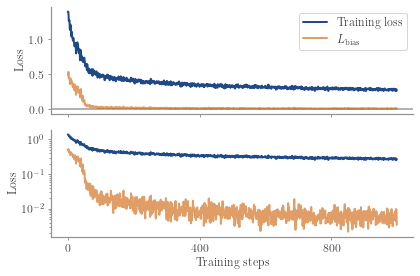

In [3]:
# Plot learning curves 
n_rows = 2
n_cols = 1
fig = plt.figure(figsize=(6, 4))
axes = subplots(fig, n_rows, n_cols, sharex=True)
i_sce = 0
for i_r in range(n_rows):
    for mi in np.ndindex(*n_mi):
        i_s, = mi
        c = colors[i_sce]
        ax = axes[i_r, 0]
        loss = loss_all[mi]
        lbl = "Training loss"
        ax.plot(steps, loss, c=c, label=lbl, alpha=1.0)
        
        lbl = r"$L_\mathrm{bias}$"
        ax.plot(steps, loss_bias[mi], c=colors[1], label=lbl, alpha=0.6)
    ax.set_ylabel("Loss")
ax = axes[0, 0]
ax.legend()
ax.axhline(0, c=c_leg, zorder=-1)
# ax.set_ylim(-0.01, 0.6)
# ax.set_ylim(-0.01, 0.02)
ax = axes[1, 0]
ax.set_yscale("log")

ax.set_xlabel("Training steps")
fig.tight_layout()
style.fixticks(fig)